Epoch 1/50


2024-11-01 17:38:16.197700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 2s 20ms/step - loss: 1.4468
Epoch 2/50
57/57 [==============================] - 2s 27ms/step - loss: 0.9327
Epoch 3/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8773
Epoch 4/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8595
Epoch 5/50
57/57 [==============================] - 2s 26ms/step - loss: 0.8345
Epoch 6/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8424
Epoch 7/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8300
Epoch 8/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8149
Epoch 9/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8299
Epoch 10/50
57/57 [==============================] - 1s 22ms/step - loss: 0.8252
Epoch 11/50
57/57 [==============================] - 1s 23ms/step - loss: 0.8175
Epoch 12/50
57/57 [==============================] - 1s 23ms/step - loss: 0.8038
Epoch 13/50
57/57 [=============================

/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_6468/3931869585.py:79: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')


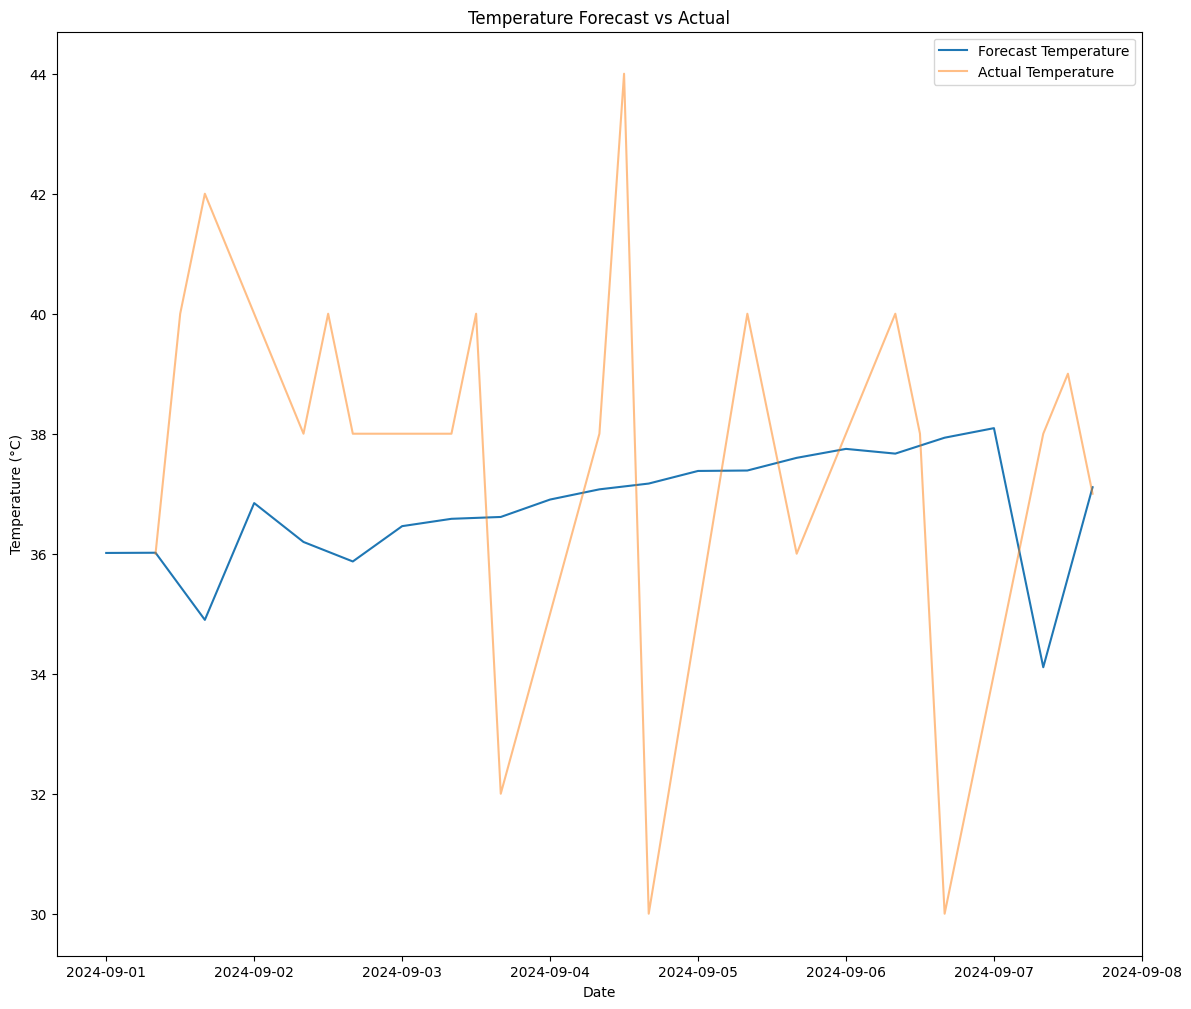

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          36.012909       1.992241 2024-09-01 00:00:00                 4   
1          36.016388       2.014427 2024-09-01 08:00:00                 4   
2          34.897568       2.418010 2024-09-01 16:00:00                 4   
3          36.844086       1.739284 2024-09-02 00:00:00                 5   
4          36.196045       1.857839 2024-09-02 08:00:00                 4   
5          35.871021       1.938578 2024-09-02 16:00:00                 4   
6          36.459488       1.844029 2024-09-03 00:00:00                 4   
7          36.581875       1.900423 2024-09-03 08:00:00                 5   
8          36.612686       1.911085 2024-09-03 16:00:00                 5   
9          36.903038       1.941103 2024-09-04 00:00:00                 5   
10         37.072975       1.953388 2024-09-04 08:00:00                 5   
11         37.169384       1.935705 2024-09-04 16:00:00                 5   

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset
data = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' to datetime object
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Sort dataset by date
data = data.sort_values(by='DATETIME')

# Identify numerical and categorical features
numerical_features = ['TEMPERATURE (°C)', 'RAINFALL (mm)']
categorical_features = ['ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Convert categorical columns to category dtype
data[categorical_features] = data[categorical_features].astype('category')

# Handle categorical data: Encode categorical features
le_condition = LabelEncoder()
le_flood = LabelEncoder()
data['ACTUAL CONDITION'] = le_condition.fit_transform(data['ACTUAL CONDITION'])
data['OCCURENCE OF FLOOD'] = le_flood.fit_transform(data['OCCURENCE OF FLOOD'])

# Scale numerical features to the range [0, 1]
scaler = MinMaxScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_features])

# Combine scaled numerical data with encoded categorical data
scaled_data = np.hstack((scaled_numerical_data, data[categorical_features].values))

# Prepare time series data
look_back = 21  # Number of time steps to look back (7 days * 3 readings/day)

# Create TimeseriesGenerator for training data
generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=32)

# Define the GRU Model
model = Sequential()
model.add(GRU(200, activation='relu', input_shape=(look_back, len(numerical_features) + len(categorical_features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(numerical_features) + len(categorical_features)))  # Output layer with multiple features

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(generator, epochs=50)

# Forecast the next 7 days (7 * 3 = 21 predictions)
n_future = 21  # Predicting 21 steps ahead (7 days of 3 readings per day)
last_data = scaled_data[-look_back:]  # Take the last 'look_back' period to predict

# Generate predictions for the next 7 days
forecast = []
input_seq = last_data.reshape((1, look_back, len(numerical_features) + len(categorical_features)))

for _ in range(n_future):
    prediction = model.predict(input_seq)
    forecast.append(prediction[0])
    # Update the input sequence with the new prediction
    input_seq = np.append(input_seq[:, 1:, :], [[prediction[0]]], axis=1)

# Convert forecast to a NumPy array
forecast = np.array(forecast)

# Convert forecast back to original scale for numerical features
forecast_numerical = scaler.inverse_transform(forecast[:, :len(numerical_features)])  # Only inverse scale numerical features

# Create a DataFrame for the forecasted data
forecast_dates = pd.date_range(start=data['DATETIME'].max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df = pd.DataFrame(forecast_numerical, columns=numerical_features)
forecast_df['DATETIME'] = forecast_dates

# Add the predicted categorical values to the forecast DataFrame
# Assuming the last two columns of the prediction correspond to the categorical features
forecast_df['ACTUAL CONDITION'] = le_condition.inverse_transform(np.round(forecast[:, len(numerical_features)]).astype(int))
forecast_df['OCCURENCE OF FLOOD'] = le_flood.inverse_transform(np.round(forecast[:, len(numerical_features) + 1]).astype(int))

# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecast Temperature')
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Forecast vs Actual')
plt.show()

# Print the forecasted DataFrame
print(forecast_df)



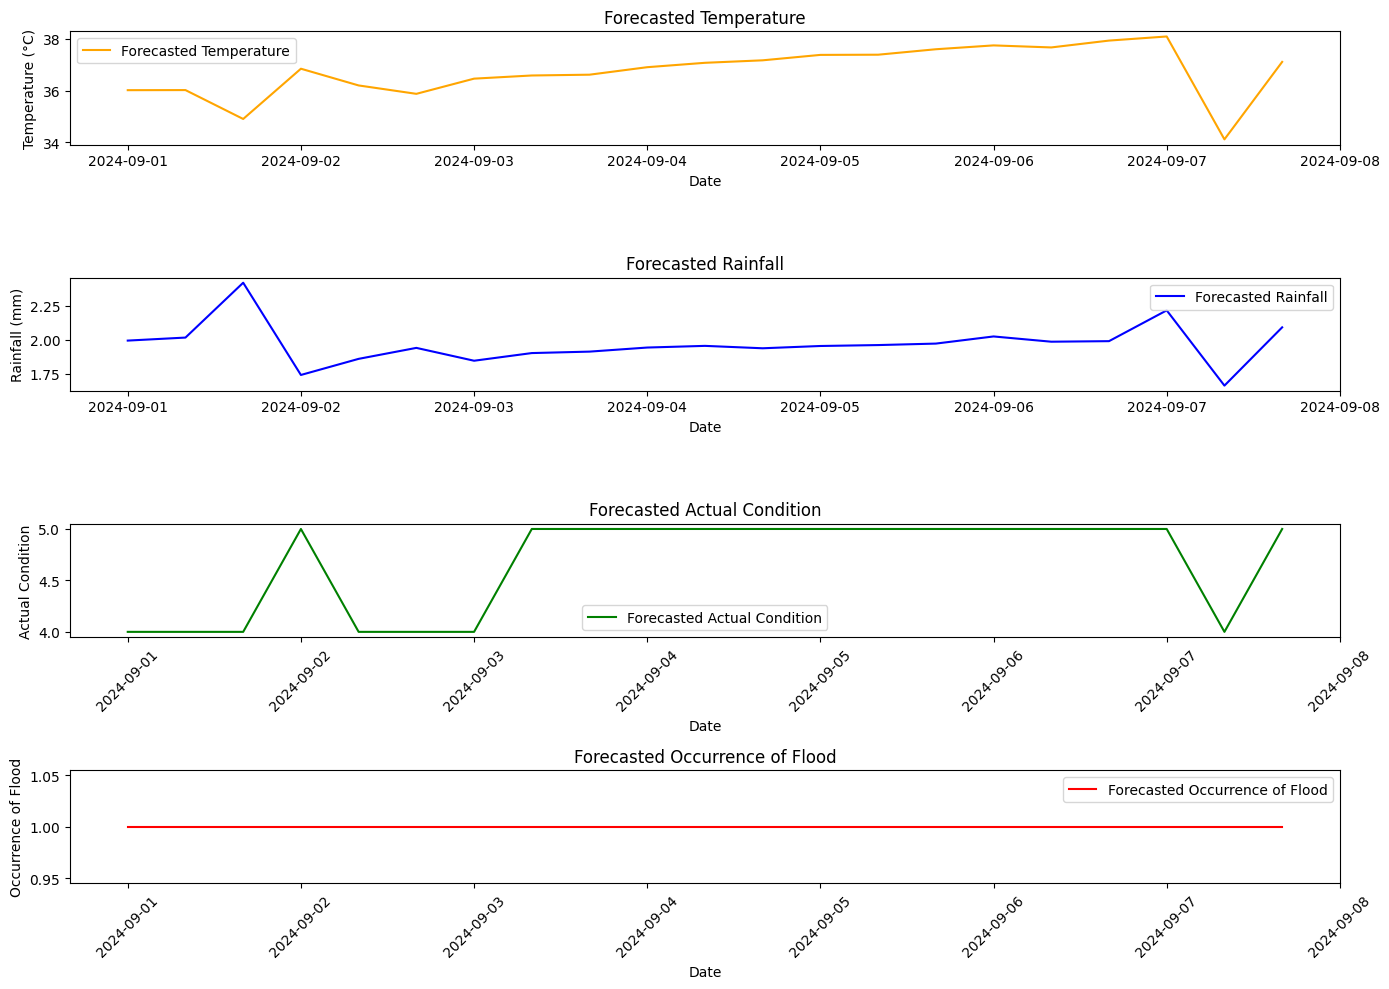

In [11]:
# Visualization of the results (optional)
plt.figure(figsize=(14, 10))

# Plot for Temperature
plt.subplot(4, 1, 1)
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Rainfall
plt.subplot(4, 1, 2)
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='blue')
plt.title('Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot for Actual Condition
plt.subplot(4, 1, 3)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Actual Condition', color='green')
plt.title('Forecasted Actual Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot for Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='red')
plt.title('Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

    TEMPERATURE (°C)  RAINFALL (mm)            DATETIME  ACTUAL CONDITION  \
0          36.012909       1.992241 2024-09-01 00:00:00                 4   
1          36.016388       2.014427 2024-09-01 08:00:00                 4   
2          34.897568       2.418010 2024-09-01 16:00:00                 4   
3          36.844086       1.739284 2024-09-02 00:00:00                 5   
4          36.196045       1.857839 2024-09-02 08:00:00                 4   
5          35.871021       1.938578 2024-09-02 16:00:00                 4   
6          36.459488       1.844029 2024-09-03 00:00:00                 4   
7          36.581875       1.900423 2024-09-03 08:00:00                 5   
8          36.612686       1.911085 2024-09-03 16:00:00                 5   
9          36.903038       1.941103 2024-09-04 00:00:00                 5   
10         37.072975       1.953388 2024-09-04 08:00:00                 5   
11         37.169384       1.935705 2024-09-04 16:00:00                 5   

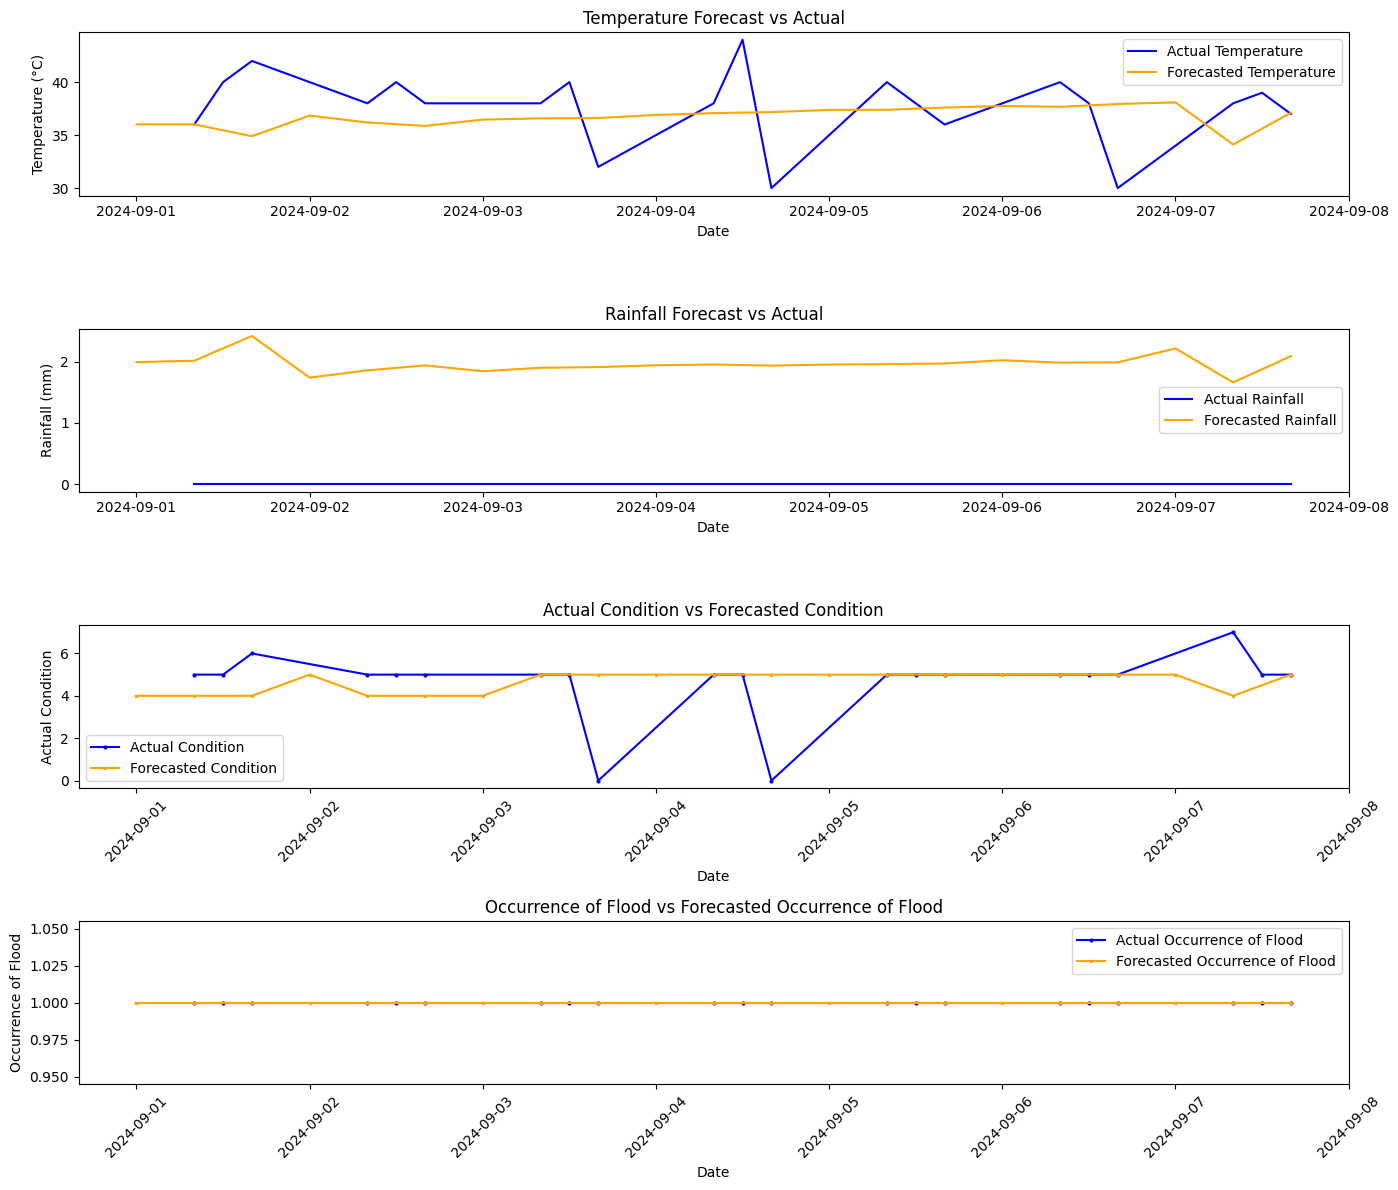

In [12]:
# Load actual data for comparison
actual_data = pd.read_csv('Actual.csv')
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Plotting the actual vs forecasted data
plt.figure(figsize=(14, 12))
print(forecast_df)
# Plot Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data['DATETIME'], actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data['DATETIME'], actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Rainfall Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()

# Plot Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data['DATETIME'], actual_data['ACTUAL CONDITION'], label='Actual Condition', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', color='orange', marker='x', markersize=2)
plt.title('Actual Condition vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Actual Condition')
plt.xticks(rotation=45)
plt.legend()

# Plot Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data['DATETIME'], actual_data['OCCURENCE OF FLOOD'], label='Actual Occurrence of Flood', color='blue', marker='o', markersize=2)
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Occurrence of Flood', color='orange', marker='x', markersize=2)
plt.title('Occurrence of Flood vs Forecasted Occurrence of Flood')
plt.xlabel('Date')
plt.ylabel('Occurrence of Flood')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()